# Import

0 : Latch:_LA_269353054_DevicePositionXOnLFAtP1;_CEID15651.4
1 : Latch:_LA_269353055_DevicePositionYOnLFAtP1;_CEID15651.5
2 : Latch:_LA_269353094_DispenseProcessAvePress;_CEID15651.7
3 : Latch:_LA_269353095_DispenseProcessAveZHeight;_CEID15651.8
4 : Latch:_LA_251920580_DispenserPressure_ECRO;_CEID15651.9
5 : Latch:_LA_269353101_PickProcessAvePickForce;_CEID15653.7
6 : Latch:_LA_269353102_PickProcessAveNeedleTopHeight;_CEID15653.8
7 : Latch:_LA_269353097_BondProcessAveBondForce;_CEID15652.6
8 : Latch:_LA_269353098_BondProcessAveBondZHeight;_CEID15652.7
9 : Latch:_LA_269353069_DiePlacementOnStripX;_CEID15652.11
10 : Latch:_LA_269353070_DiePlacementOnStripY;_CEID15652.12
11 : Latch:_LA_269353071_DiePlacementOnStripTheta;_CEID15652.13
12 : Sig:_BondProcess_PBIDiePlacementOnStripTheta_(post_Step)
13 : Sig:_BondProcess_PBIDiePlacementOnStripX_uM_(post_Step)
14 : Sig:_BondProcess_PBIDiePlacementOnStripY_uM_(post_Step)
15 : DataID


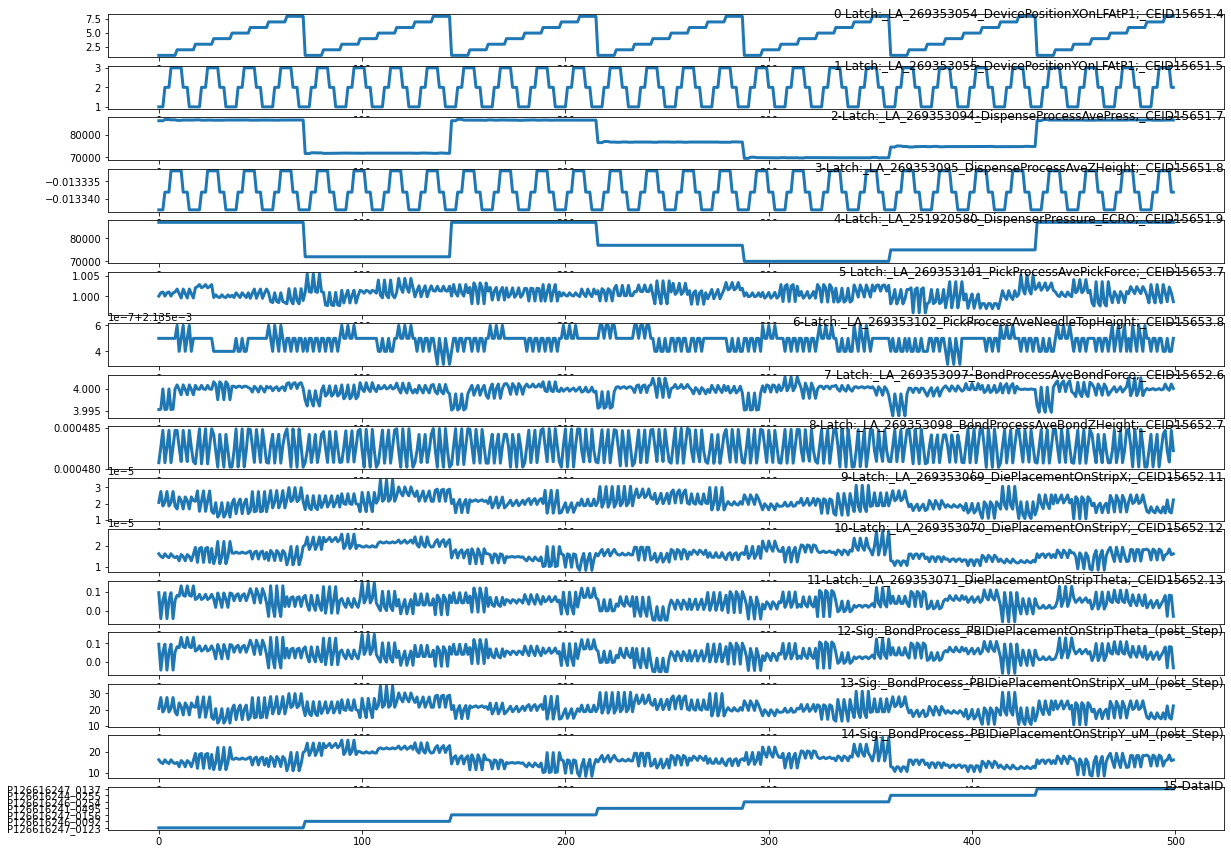

In [1]:
# Import the libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,GRU, Input, ConvLSTM2D, Bidirectional,BatchNormalization
from tensorflow.keras import Input,layers
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam,Adamax

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
import math
import json,os
from IPython.core.pylabtools import figsize
FDC_path = r"E:\FDC\dataset"
figsize(10,10) 
#FDC_Data = pd.read_csv(r'E:\FDC\dataset\data2021.csv', sep=',')

import data_vis as dv
import importlib
importlib.reload(dv)




FDC_2021Data = dv.read_data(os.path.join(FDC_path,'data_all_exclude_miss.csv'))
Y_LIST = [1,2,3,4,5,19,20,22,23,26,27,28,35,36,37,44]

X_LIST = dv.find_coi(FDC_2021Data,Y_LIST)
FDC_2021Data = FDC_2021Data.drop(FDC_2021Data.iloc[:,X_LIST],axis=1)
dv.df_col_map(FDC_2021Data)

import data_vis as dv
import importlib
importlib.reload(dv)

dv.draw_trend(FDC_2021Data,groups=range(FDC_2021Data.shape[1]),bound=500)

# Split Data

In [2]:
def gen_dataset(data,win_size):
    raw_dataset = []   #預測點的前 60 天的資料
    #y_train = []   #預測點
    for i in range(win_size, data.shape[0],win_size):
        raw_dataset.append(data[i-win_size:i, :])
        
    raw_dataset = np.array(raw_dataset)
    print("raw_dataset_shape:{}".format(raw_dataset.shape))
    return raw_dataset

In [3]:
data = np.array(FDC_2021Data.iloc[:,5:15])
targets = np.array(FDC_2021Data.iloc[:,0])
from sklearn.preprocessing import MinMaxScaler,RobustScaler

scaler = MinMaxScaler((0,1))
X_scaled = scaler.fit_transform(data)

train_data = X_scaled


train_cnt = int((train_data.shape[0]*0.8))

X_train = train_data[:train_cnt,:]
X_test  = train_data[train_cnt:,:]
y_train = np.array(FDC_2021Data.iloc[:train_cnt,0])
y_test = np.array(FDC_2021Data.iloc[train_cnt:,0])

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(780538, 10)
(195135, 10)
(780538,)
(195135,)


# Autoencoder

In [4]:
import seaborn as sns
def scatterPlot(x,y,df,color,colorName="position", a=0.65, main_title=""):
    df=df.copy()
    df[f"{colorName}"]=color
    #plt.figure(figsize=(12,9))

    s=sns.JointGrid(
        x=x, 
        y=y, 
        data=df, 
        hue=f"{colorName}",
        palette="viridis",
        height=10,
        ratio=5
        )
    s.plot_joint(sns.scatterplot, s=100, alpha=a)
    s.plot_marginals(sns.kdeplot, cut=0)
    s.fig.suptitle(main_title, fontsize=15)
    
    ax = plt.gca()
    #ax.set_title(main_title)

In [5]:
np.random.seed(123)
tf.random.set_seed(123)

comp=2
import tensorflow.keras as ks
  
INPUT = ks.layers.Input(shape=(X_train.shape[1]), name="EncoderInput")

#ENCO = ks.layers.BatchNormalization()(INPUT)
ENCO = ks.layers.Dense(32, activation='relu')(INPUT)

ENCO = ks.layers.Dropout(0.1)(ENCO)
ENCO = ks.layers.BatchNormalization()(ENCO)
ENCO = ks.layers.Dense(16, activation='relu')(ENCO)

ENCO = ks.layers.Dropout(0.1)(ENCO)
ENCO = ks.layers.BatchNormalization()(ENCO)
ENCO = ks.layers.Dense(comp, activation='linear', name="compresseion")(ENCO)

ENC = ks.Model(inputs=INPUT, outputs=ENCO)

DECO = ks.layers.BatchNormalization()(ENCO)
DECO = ks.layers.Dense(16, activation='relu')(DECO)

DECO = ks.layers.Dropout(0.1)(DECO)
DECO = ks.layers.BatchNormalization()(DECO)
DECO = ks.layers.Dense(32, activation='relu')(DECO)

DECO = ks.layers.Dropout(0.1)(DECO)
DECO = ks.layers.BatchNormalization()(DECO)
DECO = ks.layers.Dense(X_train.shape[1], activation='linear')(DECO)

AE = ks.Model(inputs=INPUT, outputs=DECO)

In [9]:
def rmse(y_pred, y_true):
    y_pred = tf.cast(y_pred, dtype="float32")
    y_true = tf.cast(y_true, dtype="float32")
    r = tf.sqrt(tf.keras.backend.mean(tf.square(y_pred - y_true)))
    return r

stop = ks.callbacks.EarlyStopping(
    monitor='mae', 
    min_delta=0.000001, 
    patience=100, 
    mode='max'
    )

lrReducer = ks.callbacks.ReduceLROnPlateau(    
    monitor="val_loss",
    factor=0.5,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.000001,
    )

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "./Best_AE.h5",
    monitor="val_mae",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
    options=None
)

eps=1500
bs=1600
leRa=0.1
dec = 0.0000

"Learning rate and decay ok?: " + str(leRa - dec * eps > 0)

'Learning rate and decay ok?: True'

In [15]:
optimizer = ks.optimizers.Adamax(learning_rate=leRa, decay=dec)
AE.compile(optimizer = optimizer, loss = rmse, metrics = ["mae"])

In [11]:
Reduced = ENC.predict(
   x=X_test, 
   workers = 1, 
   use_multiprocessing = True
)

Reduced = pd.DataFrame(Reduced)

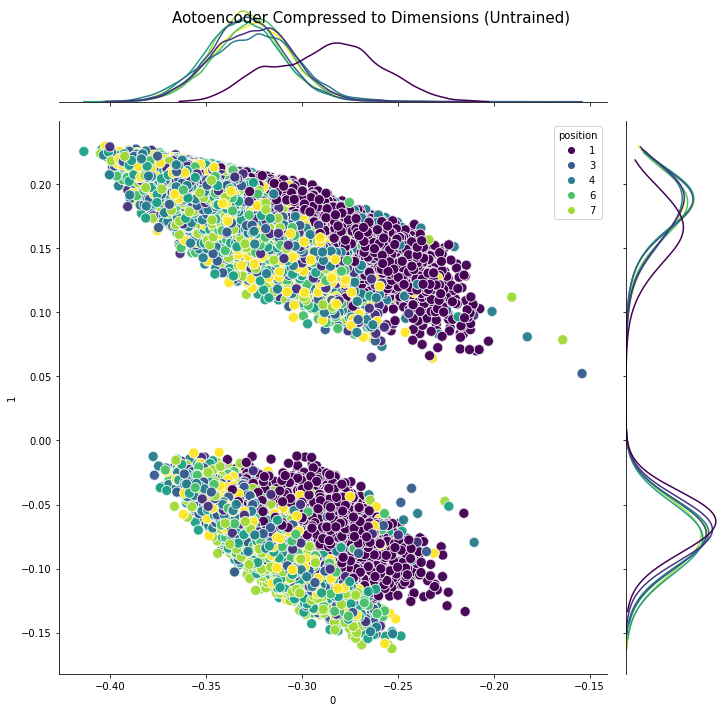

In [197]:
scatterPlot(x=0,y=1,df=Reduced,color=y_test, main_title="Aotoencoder Compressed to Dimensions (Untrained)")

In [16]:
history = ks.callbacks.History()

AE.fit(
    x=X_train, 
    y=X_train, 
    epochs = 100, 
    batch_size = 128, 
    shuffle = False,
    callbacks=[history, lrReducer,checkpoint],
    verbose=1,
    validation_split=0.2
    )



#print(AE.evaluate(Data.drop(columns=["quality"]), Data.drop(columns=["quality"])))

Epoch 1/100
4879/4879 [==============================] - 45s 9ms/step - loss: 0.0654 - mae: 0.0458 - val_loss: 0.1088 - val_mae: 0.0748

Epoch 00001: val_mae improved from inf to 0.07479, saving model to .\Best_AE.h5
Epoch 2/100
4879/4879 [==============================] - 44s 9ms/step - loss: 0.0616 - mae: 0.0428 - val_loss: 0.0828 - val_mae: 0.0552

Epoch 00002: val_mae improved from 0.07479 to 0.05519, saving model to .\Best_AE.h5
Epoch 3/100
4879/4879 [==============================] - 43s 9ms/step - loss: 0.0620 - mae: 0.0431 - val_loss: 0.0788 - val_mae: 0.0532

Epoch 00003: val_mae improved from 0.05519 to 0.05322, saving model to .\Best_AE.h5
Epoch 4/100
4879/4879 [==============================] - 43s 9ms/step - loss: 0.0615 - mae: 0.0428 - val_loss: 0.0816 - val_mae: 0.0521

Epoch 00004: val_mae improved from 0.05322 to 0.05211, saving model to .\Best_AE.h5
Epoch 5/100
4879/4879 [==============================] - 43s 9ms/step - loss: 0.0614 - mae: 0.0428 - val_loss: 0.0808 - 

In [12]:
Reduced = ENC.predict(
   x=X_test, 
   workers = 1, 
   use_multiprocessing = True
)

Reduced = pd.DataFrame(Reduced)

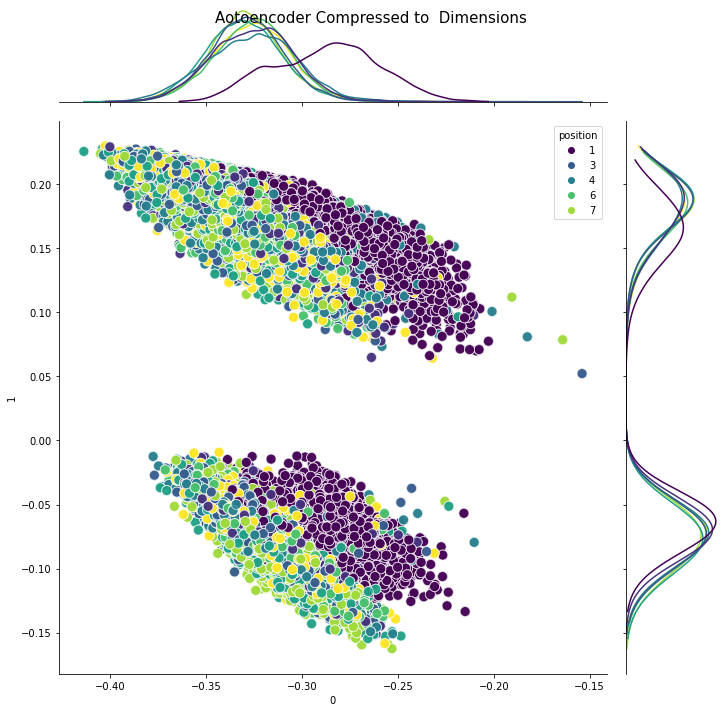

In [13]:
scatterPlot(x=0,y=1,df=Reduced,color=y_test, main_title="Aotoencoder Compressed to  Dimensions")